In [647]:
#importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [648]:
#Loading data
df = pd.read_csv('AAPL_2006-01-01_to_2018-01-01.csv')
df = df.drop(columns=["Name"])
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date").set_index("Date")

data = df.values

In [649]:
#Just to get an idea of the shape
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2006-01-03,10.34,10.68,10.32,10.68,201853036
2006-01-04,10.73,10.85,10.64,10.71,155225609
2006-01-05,10.69,10.70,10.54,10.63,112396081
2006-01-06,10.75,10.96,10.65,10.90,176139334
2006-01-09,10.96,11.03,10.82,10.86,168861224


In [650]:
#Creating the sequential data for RNN
def create_sequences(data, seq_length, target_col):
    xs = []
    ys = []

    #Using lists to take data indices and returning them as np arrays
    for i in range(len(data) - seq_length):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length, target_col]
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

In [651]:
#Preprocessing
scalerX = StandardScaler()
scalerY = StandardScaler()

SEQ_LEN = 30 #sequence length

#Split the data
train_size = int(len(data)*0.8)
test_size = int(len(data)*0.2)
target_col = 4 #col dor CLOSED value

X = data[:, :target_col]
y = data[:, target_col]
y = y.reshape(-1, 1)         # scaler expects 2D

trainX = X[:train_size]
testX  = X[train_size:]

trainY = y[:train_size]
testY  = y[train_size:]

#Z score
trainX = scalerX.fit_transform(trainX)
trainY = scalerY.fit_transform(trainY)

testX = scalerX.transform(testX)
testY = scalerY.transform(testY)

#Creating sequential data
trainX, trainY = create_sequences(np.concatenate([trainX, trainY], axis=1), SEQ_LEN, target_col)
testX, testY = create_sequences(np.concatenate([testX, testY], axis=1), SEQ_LEN, target_col)

#And put everything into tensors for torch
trainX = torch.tensor(trainX, dtype=torch.float32)
testX = torch.tensor(testX, dtype=torch.float32)
trainY = torch.tensor(trainY, dtype=torch.float32)
testY = torch.tensor(testY, dtype=torch.float32)

RNN Model

In [652]:
#RNN model
class RNN(nn.Module): #Class def for network and architecture
  def __init__(self, input_size=5, hidden_size=56, num_layers=1, output_size=1):
    super(RNN, self).__init__()
    self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
    self.fc = nn.Linear(hidden_size, output_size)

  def forward(self, x): #Forward pass
    out, _ = self.rnn(x)
    out = self.fc(out[:, -1, :])
    return out

In [653]:
#Create network
RNN_model = RNN()

#Parameters for it
lr = 0.01
num_epochs = 50
criterion = nn.HuberLoss() #vs MSELoss()
optimizer = optim.Adam(RNN_model.parameters(), lr=lr)
lossList = []

#Run the training
for epoch in range(num_epochs):
  RNN_model.train()
  output = RNN_model(trainX)

  loss = criterion(output, trainY.view(-1, 1).float())

  optimizer.zero_grad()
  loss.backward()
  #torch.nn.utils.clip_grad_norm_(RNN_model.parameters(), max_norm=0.5) NO HELP
  optimizer.step()

  lossList.append(loss.item())

  if (epoch + 1) % 10 == 0:
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/50], Loss: 0.1364
Epoch [20/50], Loss: 0.1234
Epoch [30/50], Loss: 0.1229
Epoch [40/50], Loss: 0.1210
Epoch [50/50], Loss: 0.1204


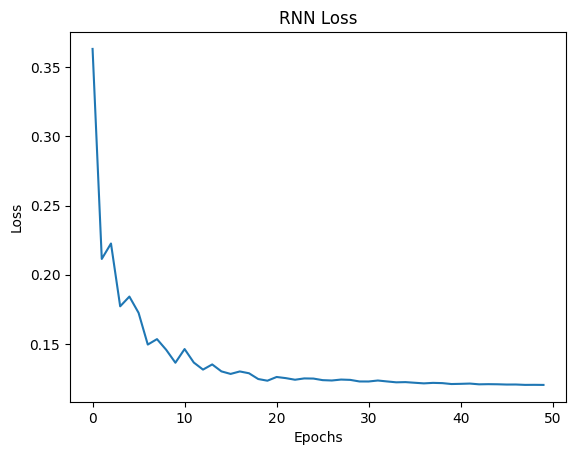

In [658]:
#Plotting the Loss during learning
plt.plot(lossList)
plt.xlabel('Epochs')
plt.ylabel('Loss')
title = 'RNN Loss'
plt.title(title)
plt.show()

In [655]:
#Evaluation of RNN
RNN_model.eval()

#Run test data through network
with torch.no_grad():
  pred = RNN_model(testX).numpy()
  pred = scalerY.inverse_transform(pred)

#Inverse z score
testY = scalerY.inverse_transform(testY.reshape(-1, 1))

#Some metrics
mae = mean_absolute_error(testY, pred)
rmse = np.sqrt(mean_squared_error(testY, pred))
r2 = r2_score(testY, pred)
mape = np.mean(np.abs((testY - pred) / testY)) * 100

#And printing them
print("MAE :", mae)
print("RMSE:", rmse)
print("R²  :", r2)
print("MAPE:", mape)

MAE : 9659905.381145008
RMSE: 13003144.102089357
R²  : 0.31991524197374177
MAPE: 30.45900215988464


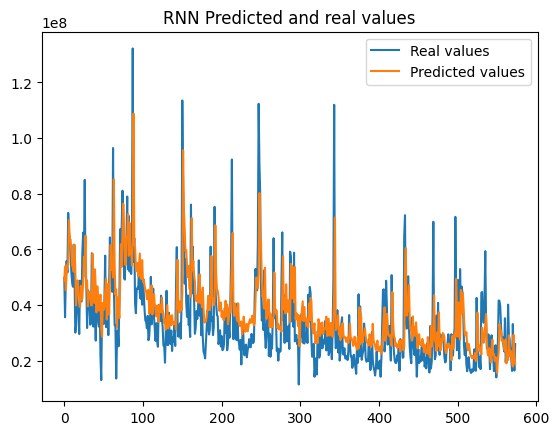

In [656]:
#Plotting Real and predicted for better visual
plt.plot(testY, label='True')
plt.plot(pred, label='Predicted')
plt.legend(["Real values", "Predicted values"])
plt.title("RNN Predicted and real values")
plt.show()